# <FONT size="10pt"> <center>Projet 7</center></FONT>


### Notebook 2

#### <FONT size="10pt"> <center>Implémentez un modèle de scoring</center></FONT>



### Mission de Data Scientist pour "Prêt à dépenser"

En tant que Data Scientist chez "Prêt à dépenser", une société financière spécialisée dans les crédits à la consommation pour des clients ayant peu ou pas d'historique de prêt, vous êtes chargé de développer un outil de "scoring crédit" pour évaluer la probabilité qu'un client rembourse son prêt.

#### Objectifs de la mission :

1. **Construction du Modèle de Scoring** :
   - Développer un algorithme de classification capable de prédire automatiquement la probabilité de faillite d'un client en utilisant des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

2. **Analyse des Features** :
   - Identifier les caractéristiques (features) qui contribuent le plus au modèle de manière générale (importance globale des features).
   - Analyser l'importance des features au niveau individuel (importance locale des features) pour permettre aux chargés d'études de comprendre le score attribué à chaque client.

3. **Mise en Production** :
   - Déployer le modèle de scoring via une API.
   - Créer une interface de test pour cette API afin de faciliter son utilisation et sa validation.

4. **Approche MLOps** :
   - Mettre en place une approche MLOps complète, incluant le suivi des expérimentations et l'analyse du data drift en production pour assurer la robustesse et la pertinence continue du modèle.


### Les données :

1. **application_train/application_test** : Ces fichiers contiennent les données principales pour l'entraînement et le test. Chaque ligne représente une demande de prêt chez Prêt à dépenser, identifiée par l'attribut SK_ID_CURR. Les données d'entraînement incluent une colonne TARGET indiquant si le prêt a été remboursé (0) ou non (1).

2. **bureau** : Ce fichier contient des informations sur les crédits antérieurs des clients auprès d'autres institutions financières. Chaque ligne correspond à un crédit antérieur, et un prêt existant dans application_train/application_test peut être associé à plusieurs crédits antérieurs.

3. **bureau_balance** : Ces données mensuelles fournissent des informations sur les crédits antérieurs mentionnés dans le fichier bureau. Chaque ligne correspond à un mois de crédit, et un crédit unique peut avoir plusieurs lignes, une pour chaque mois de sa durée.

4. **previous_application** : Ce fichier recense les demandes de prêts précédentes des clients auprès de Prêt à dépenser. Chaque ligne correspond à une demande antérieure de prêt, identifiée par l'attribut SK_ID_PREV. Un prêt actuel dans application_train/application_test peut avoir plusieurs demandes de prêts antérieures.

5. **POS_CASH_BALANCE** : Ces données mensuelles concernent les prêts au point de vente ou les prêts en espèces contractés par les clients auprès de Prêt à dépenser. Chaque ligne représente un mois de prêt au point de vente ou de prêt en espèces, avec plusieurs lignes possibles pour un même prêt.

6. **credit_card_balance** : Ce fichier contient des données mensuelles sur les cartes de crédit des clients. Chaque ligne correspond à un mois de solde de carte de crédit, avec plusieurs lignes possibles pour une même carte de crédit.

7. **installments_payment** : Ce fichier documente l'historique des paiements pour les prêts antérieurs. Chaque ligne représente un paiement effectué ou manqué.

L'objectif est de combiner ces différentes sources de données pour construire un modèle de scoring précis qui peut aider Prêt à dépenser à évaluer le risque de crédit de leurs clients.

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [1]:
### Importations de base
import numpy as np
import pandas as pd
import os
import gc
import time
import timeit
import datetime
import random
import statistics
import warnings
from contextlib import contextmanager

### Importations pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import missingno as msno
from tqdm.notebook import tqdm
from IPython.display import display, HTML

### Importations pour la manipulation des données
import re
from scipy import stats

### Importations pour le Machine Learning
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc,  roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn import cluster, metrics
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

### Importations pour MLFLOW
import mlflow
import mlflow.sklearn

### Importations pour SHAP et gestion des avertissements spécifiques
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import shap
shap.initjs()
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Paramètres pandas
pd.set_option('mode.chained_assignment', None)  # Pour éviter la survenue de messages d'erreur lors de la création d'un nouveau dataframe à partir d'un existant
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.display.width = 50
pd.options.display.max_colwidth = 1000

### Optionnel : Ajuster la largeur de l'écran pour IPython
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

**Concernant l’élaboration du modèle soyez vigilant sur deux points spécifiques au contexte métier :** 

- Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix.
- Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge).
   - Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
   - Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

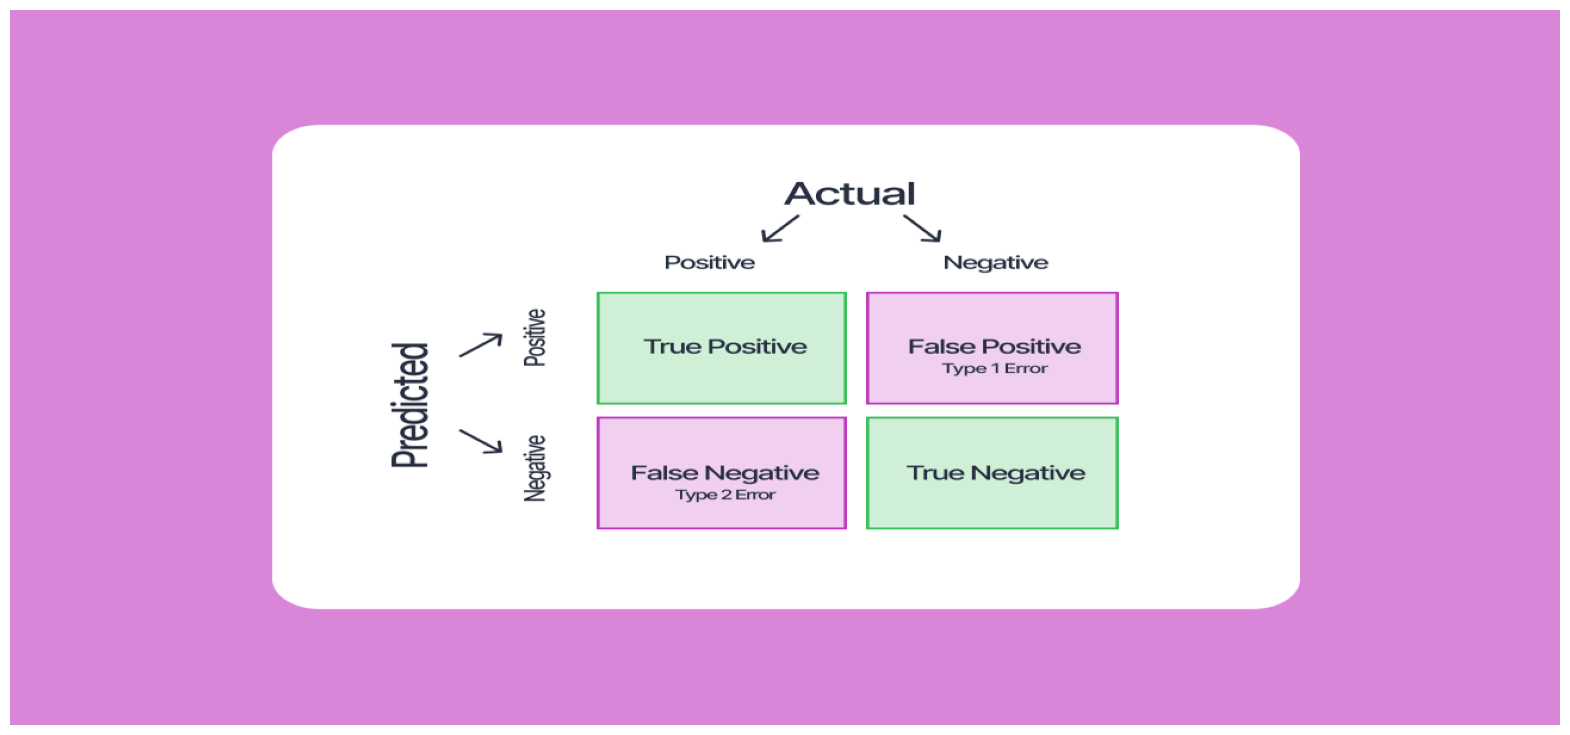

In [2]:
from PIL import Image

# Chemin vers l'image
image_path = 'Confusion.png'

# Ouvrir l'image
image = Image.open(image_path)
image = image.convert('RGB')
# Redimensionner l'image (ajuster les dimensions selon vos besoins)
image_resized = image.resize((1300, 600))

# Ajuster la taille de la figure
plt.figure(figsize=(20, 12))

# Afficher l'image
plt.imshow(image_resized)
plt.axis('off')  # Pour cacher les axes
plt.show()

# Fonctions

In [3]:
# Calcul de l'exactitude (Accuracy) du modèle :
def calculate_accuracy(model, X_train, X_test):
    """
    Calcule l'exactitude (accuracy) du modèle sur les ensembles d'entraînement et de test.

    Paramètres :
    - model : Le modèle entraîné.
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.

    Retourne :
    - accuracy_train : L'exactitude sur l'ensemble d'entraînement.
    - accuracy_test : L'exactitude sur l'ensemble de test.
    """
    # Utilisation des variables globales y_train et y_test pour les étiquettes cibles
    accuracy_train = round(model.score(X_train, y_train), 3)
    accuracy_test = round(model.score(X_test, y_test), 3)
    
    # Retourne l'exactitude pour les ensembles d'entraînement et de test
    return accuracy_train, accuracy_test


# Mesure personnalisée pour accorder plus d'importance aux faux négatifs coûteux pour l'entreprise :
def calculate_custom_metric(true_labels, predicted_probabilities):
    """
    Calcule une métrique personnalisée qui pénalise davantage les faux négatifs
    et retourne le score minimal ainsi que le seuil optimal.

    Paramètres :
    - true_labels : Les étiquettes cibles réelles.
    - predicted_probabilities : Les probabilités prédites par le modèle.

    Retourne :
    - lowest_penalty_score : Le meilleur score obtenu avec la probabilité de seuil optimale.
    - best_threshold : La probabilité de seuil optimale associée au meilleur score.
    """
    best_threshold = 12  # Initialisation de la meilleure probabilité de seuil (valeur par défaut)
    lowest_penalty_score = 10  # Initialisation du score de pénalité le plus bas avec une valeur élevée (10)
    #lowest_penalty_score = float('inf')  # Initialisation du score de pénalité le plus bas avec une très grande valeur (infini)
    
    # Itération sur les probabilités de seuil de 0.30 à 1.00 (par pas de 0.01)
    for threshold in range(30, 101):
        # Génère les étiquettes prédictives binaires en utilisant la probabilité de seuil actuelle
        predicted_labels = [1 if prob >= threshold / 100 else 0 for prob in predicted_probabilities]
        
        # Calcule la matrice de confusion pour comparer les prédictions aux valeurs réelles
        confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
        
        # Calcule une métrique personnalisée qui accorde un poids plus important aux faux négatifs
        penalty_score = round(
            ((confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1]) /
            (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1] +
             confusion_matrix_result[0][0] + confusion_matrix_result[1][1])), 3
        )
        
        # Si le score actuel est meilleur (plus petit) que le score précédent,
        # mettre à jour le meilleur score et la meilleure probabilité de seuil
        if penalty_score < lowest_penalty_score:
            lowest_penalty_score = penalty_score
            best_threshold = threshold / 100  # Mise à jour de la meilleure probabilité de seuil
    
    # Retourne le meilleur score trouvé et la probabilité de seuil optimale
    return lowest_penalty_score, best_threshold


def calculate_auc(model, X_train, X_test):
    """
    Calcule l'AUC (Area Under the ROC Curve) du modèle sur les ensembles d'entraînement et de test.

    Paramètres :
    - model : Le modèle entraîné.
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.

    Retourne :
    - roc_train : L'AUC sur l'ensemble d'entraînement.
    - roc_test : L'AUC sur l'ensemble de test.
    """
    # Calcule l'AUC sur l'ensemble d'entraînement en utilisant les probabilités prédites par le modèle
    roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    
    # Calcule l'AUC sur l'ensemble de test en utilisant les probabilités prédites par le modèle
    roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Retourne les valeurs AUC pour les ensembles d'entraînement et de test
    return roc_train, roc_test

In [4]:
# Détermination de la meilleure probabilité de seuil :
def best_threshold_probability(y_true, predicted_probabilities):
    """
    Détermine la meilleure probabilité de seuil pour minimiser une métrique personnalisée
    qui pénalise davantage les faux négatifs.

    Paramètres :
    - y_true : Les étiquettes cibles réelles.
    - predicted_probabilities : Les probabilités prédites par le modèle.

    Retourne :
    - best_threshold : La meilleure probabilité de seuil trouvée pour minimiser la métrique.
    """
    best_threshold = 12  # Initialisation de la meilleure probabilité de seuil (valeur par défaut)
    lowest_penalty_score = 10  # Initialisation du meilleur score avec une valeur élevée (10)
    ##lowest_penalty_score = float('inf')  # Initialisation du score de pénalité le plus bas avec une très grande valeur (infini)

    # Boucle pour tester différentes probabilités de seuil de 0.30 à 1.00 (par pas de 0.01)
    for threshold in range(30, 101):
        # Crée la prédiction binaire (0 ou 1) en fonction de la probabilité de seuil courante (threshold/100)
        predicted_labels = [1 if probability >= threshold / 100 else 0 for probability in predicted_probabilities]
        
        # Calcule la matrice de confusion pour comparer les prédictions aux valeurs réelles
        confusion_matrix_result = confusion_matrix(y_true, predicted_labels)
        
        # Calcule la métrique personnalisée qui pénalise davantage les faux négatifs
        penalty_score = round(
            (
                (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1]) /
                (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1] +
                 confusion_matrix_result[0][0] + confusion_matrix_result[1][1])
            ), 3
        )
        
        # Si le score actuel est meilleur (plus petit) que le meilleur score précédent, met à jour le meilleur score
        # et la meilleure probabilité de seuil
        if penalty_score < lowest_penalty_score:
            lowest_penalty_score = penalty_score
            best_threshold = threshold / 100  # Mise à jour de la meilleure probabilité de seuil
    
    return best_threshold  # Retourne la meilleure probabilité de seuil trouvée

# Création d'une fonction score personnalisée pour GridSearchCV ou autres modèles nécessitant une métrique spécifique :
#custom_threshold_scorer = make_scorer(best_threshold_probability, needs_proba=True)
custom_threshold_scorer = make_scorer(best_threshold_probability, response_method='predict_proba')

In [5]:
# Division des données en ensembles d'entraînement et de test :
def split_train_test_data(features, target):
    """
    Divise les données en ensembles d'entraînement et de test.

    Paramètres :
    - features : Les variables indépendantes (X).
    - target : La variable cible (y).

    Retourne :
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.
    - y_train : Les données d'entraînement pour la variable cible.
    - y_test : Les données de test pour la variable cible.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.7, random_state=42, stratify=target)
    return X_train, X_test, y_train, y_test

In [6]:
# Définir la variable globale Unbalance
Unbalance = 'WEIGHT'

def MLFLOW(model, training_features, testing_features):
    """
    Enregistre les résultats du modèle sur MLFlow, y compris les métriques de performance,
    les graphiques et les paramètres du modèle.
    """
    
    # Identification de l'interface MLflow pour suivre les expérimentations
    mlflow.set_tracking_uri("file:///C:\\Users\\Infogene\\Documents\\Khoty_Privé\\DOSSIER FORMATION DATA SCIENTIST\\PROJET 7 ML\\Notebook\\mlflow_runs")
    
    # Définition de l'expérience MLflow
    experiment_name_prefix = 'MLFlowProjet7 - BestModel - '  # Préfixe pour le nom de l'expérience
    unbalance_status = Unbalance  # Statut de déséquilibre utilisé pour compléter le nom de l'expérience
    mlflow.set_experiment(experiment_name_prefix + unbalance_status)

    with mlflow.start_run() as run:
        
        # Définition du nom du RUN basé sur la date actuelle et le nom du modèle
        model_name = str(model).split('(')[0]
        mlflow.set_tag("mlflow.runName", datetime.datetime.today().strftime('%Y-%m-%d') + ' - ' + model_name)

        # Démarrage du chronomètre pour mesurer la durée d'entraînement du modèle
        start_time = timeit.default_timer()

        # Entraînement du modèle avec les données d'entraînement
        model = model.fit(training_features, y_train) 

        # Fin du chronomètre et enregistrement de la durée sur MLflow
        elapsed_time = timeit.default_timer() - start_time
        mlflow.log_metric("Duree Run", elapsed_time)

        # Enregistrement des paramètres du modèle sur MLflow
        mlflow.log_params(model.get_params())
        
        # Enregistrement du nombre de variables utilisées (colonnes) dans l'ensemble d'entraînement
        num_features = len(training_features.columns)
        mlflow.log_metric('Nb Variables', num_features)

        # Calcul et enregistrement des métriques de performance :
        
        # Calcul de l'accuracy (exactitude) sur les ensembles d'entraînement et de test
        train_accuracy, test_accuracy = calculate_accuracy(model, training_features, testing_features)
        mlflow.log_metric("Accuracy Train", train_accuracy)
        mlflow.log_metric("Accuracy Test", test_accuracy)

        # Calcul de l'AUC (Area Under the ROC Curve) sur les ensembles d'entraînement et de test
        train_auc, test_auc = calculate_auc(model, training_features, testing_features)
        mlflow.log_metric("AUC Train", round(train_auc, 3))
        mlflow.log_metric("AUC Test", round(test_auc, 3))
        
        # Calcul de la métrique personnalisée et de la meilleure probabilité de seuil sur l'ensemble d'entraînement
        predicted_train_probabilities = model.predict_proba(training_features)[:, 1]
        custom_train_metric, best_threshold = calculate_custom_metric(y_train, predicted_train_probabilities)
        mlflow.log_metric("Metric Perso Train", round(custom_train_metric, 3))
        mlflow.log_metric("Metric Best Pourcentage", round(best_threshold, 3))
              
        # Enregistrement des graphiques :
        
        # Matrice de confusion pour les prédictions sur l'ensemble de test
        predicted_test_labels = model.predict(testing_features)
        confusion_matrix_result = confusion_matrix(y_test, predicted_test_labels, labels=model.classes_)
        confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result)
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
        plt.title('Matrice de Confusion pour le modèle {}.'.format(model_name))
        confusion_display.plot(ax=ax1)
        mlflow.log_figure(fig, "ConfMat.png")
        plt.close(fig)

        # Courbe ROC pour les prédictions sur l'ensemble de test
        predicted_test_probabilities = model.predict_proba(testing_features)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_test_probabilities)
        roc_auc = metrics.auc(fpr, tpr)
        roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
        plt.title('ROC Curve pour le modèle {}.'.format(model_name))
        roc_display.plot(ax=ax1)
        mlflow.log_figure(fig, "ROCCurve.png")
        plt.close(fig)

        # Enregistrement du modèle sur MLflow
        mlflow.sklearn.log_model(model, "model")
        
        # Fin du RUN sur MLflow
        mlflow.end_run()
        
        # Compilation des résultats pour retour dans un tableau Python
        results = [model_name, round(elapsed_time), num_features, train_accuracy, test_accuracy, 
                   round(train_auc, 3), round(test_auc, 3), custom_train_metric, best_threshold]
        
        # Retourne les résultats
        return results

# Apprentissage automatique ou machine learning

## Fichier Prétraité

In [7]:
# Chargement des données depuis le fichier CSV "AnciensClients.csv"
Data = pd.read_csv(r'C:\Users\Infogene\Documents\Khoty_Privé\DOSSIER FORMATION DATA SCIENTIST\PROJET 7 ML\Application\Donnees_generees\AnciensClients.csv')
Data.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRA

In [8]:
# Affiche les dimensions du DataFrame (nombre de lignes et de colonnes)
data_shape = Data.shape
print(f"Dimensions du DataFrame : {data_shape}")

print()

# Affiche des informations générales sur le DataFrame, telles que le type de chaque colonne et le nombre de valeurs non nulles
Data_info = Data.info()

print()

# Affiche la répartition des classes pour la colonne 'TARGET', y compris les NaN (non applicable ici car 'TARGET' est binaire)
target_distribution = Data['TARGET'].value_counts(dropna=False)
print("Répartition des classes de 'TARGET' :")
print(target_distribution)

print()

# Calcul et affichage du nombre total de valeurs manquantes (NaN) dans le DataFrame
total_missing_values = Data.isna().sum().sum()
print(f"Quantité totale de valeurs manquantes (NaN) : {total_missing_values}")

print()

# Calcul et affichage du nombre total de cellules dans le DataFrame (nombre de lignes * nombre de colonnes)
total_cells = Data.shape[0] * Data.shape[1]
print(f"Nombre total de cellules dans le DataFrame : {total_cells}")

print()

# Renomme les colonnes du DataFrame en supprimant les caractères spéciaux et en conservant uniquement les lettres, chiffres et underscores
Data = Data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
print("Les colonnes du DataFrame ont été renommées pour supprimer les caractères spéciaux.")

Dimensions du DataFrame : (307506, 796)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 796 entries, TARGET to INSTAL_COUNT
dtypes: float64(796)
memory usage: 1.8 GB

Répartition des classes de 'TARGET' :
0.0    282681
1.0     24825
Name: TARGET, dtype: int64

Quantité totale de valeurs manquantes (NaN) : 63543285

Nombre total de cellules dans le DataFrame : 244774776

Les colonnes du DataFrame ont été renommées pour supprimer les caractères spéciaux.


### Data preparation

#### X et y

In [9]:
# créer le vecteur d'étiquettes
y = Data['TARGET']

# créer la matrice de données
X = Data.iloc[:,1:]

In [10]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_C

In [11]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

#### test train split

In [13]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

In [14]:
print(f"nous avons X_train de forme {X_train.shape} et y_train de forme  {y_train.shape} ")
print(f"nous avons X_test de forme {X_test.shape} et y_test de forme  {y_test.shape} ")

nous avons X_train de forme (215254, 795) et y_train de forme  (215254,) 
nous avons X_test de forme (92252, 795) et y_test de forme  (92252,) 


### Modelisation

###  Dummy classifier

In [15]:
# Nous allons instancier un objet le "DummyClassifier" et lui spécilier une strategie "most_frequent"
  # et Stocké l'objet instancier dans une variable "estimator" et ensuite faire l'entrainement de cet estimateur

estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [16]:
# Appelons la methode predict() sur X_test
# vecteur de prediction

y_pred = estimator.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Nous voyons ici un vecteur, c'est un objet numpy mais c'est considerer comme un vecteur. Nous avons l'impression a premiere vue qu'il y a des 0 dans ce vecteur

In [17]:
# calculons les valeurs présente dans ce vecteur
pd.Series(y_pred).value_counts()

0.0    92252
dtype: int64

In [18]:
# fréquence
y_test.value_counts(normalize=True)

0.0    0.919265
1.0    0.080735
Name: TARGET, dtype: float64

La classe zéro(0) est plus présente que la classe 1

In [19]:
y_test.values

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
def score(estimator):
    """Compute and print various evaluation metrics for train and test sets."""
    
    # Prédictions pour l'ensemble d'entraînement et de test
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    # Prédictions de probabilité pour l'AUC et les autres métriques basées sur des seuils
    y_train_proba = estimator.predict_proba(X_train)[:, 1]
    y_test_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    accuracy_train = round(accuracy_score(y_train, y_train_pred), 4)
    accuracy_test = round(accuracy_score(y_test, y_test_pred), 4)
    
    auc_train = round(roc_auc_score(y_train, y_train_proba), 4)
    auc_test = round(roc_auc_score(y_test, y_test_proba), 4)
    
    # Calcul de la métrique personnalisée et de la meilleure probabilité de seuil
    custom_train_metric, best_threshold_train = calculate_custom_metric(y_train, y_train_proba)
    custom_train_metric = round(custom_train_metric, 4)
    best_threshold_train = round(best_threshold_train, 4)
    
    # Affichage des résultats
    print(f"score train : {accuracy_train} | score test : {accuracy_test}")
    print(f"AUC train : {auc_train} | AUC test : {auc_test}")
    print(f"Custom metric train : {custom_train_metric}")
    print(f"Best threshold probability : {best_threshold_train}")

In [21]:
score(estimator)

score train : 0.9193 | score test : 0.9193
AUC train : 0.5 | AUC test : 0.5
Custom metric train : 0.468
Best threshold probability : 0.3


Prémièrement nous voyons ici que les scores de **train** et de **test** sont très proche.

deuxièment ils sont très proche de la **fréquence** de l'apparution de la valeur zéro (0).

Tout ceux ci nous permet de valider que nos données peuvent bien fonctionnées dans le cadre d'une modelisation.
Aussi, cela permet d'avoir un **score de base**. c'est à dire l'estimateur le plus simple possible nous renvoie un score, un accuracis score de 0.51 et donc l'ameliration de notre modelisation se fait dans la fourchette **0.91** jusqu'a **1**. 

Et Oui c'est un petit piège, si notre **score** était de **zéro(0)** sa ne voudrait pas dire que nous aurions une mauvaise modelisation. sa voudrait dire que nous somme à chaque fois capable de predire l'inverse du résultat attendu. autrement dit si on prenait le vecteur de prediction d'un modele qui à une **accuracy score à zéro(0)** et qu'on prenait son inverse on aurait un **accuracy score à 1**.
Donc attention, prenez toujour en score de référence, le score qui est propsé par le **DummyClssifier** dans notre cas ou le **DummyRegressor** dans un autre cas. C'est vraiment la **baseline** que nous allons utilisé

- **L'accuracis score est le nombre de bonne prediction que nous faisons par rapport l'ensemble des predictions**

In [22]:
def confusion(y_true, y_pred):
    """Display a fancy confusion matrix."""
    
    mat = confusion_matrix(y_true, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"actual_{i}" for i in mat.index]
    
    return mat

In [23]:
confusion(y_test, y_pred)

,pred_0,pred_1
actual_0,84804,0
actual_1,7448,0


In [24]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

Text(0.5, 0, 'False Positive Rate')

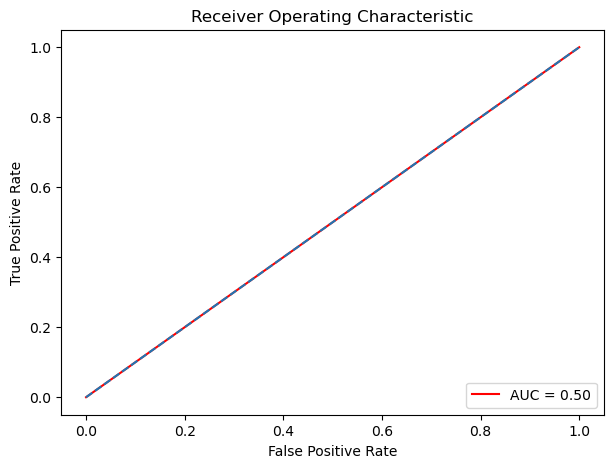

In [25]:
plt.figure(figsize=(7,5))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, color="red", label="AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1], [0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")   
plt.xlabel("False Positive Rate")

**Pourquoi utiliser un classifieur naïf ?**

Valider que la **forme** des données est compatible avec une modélisation.

Avoir un **score de base**. On utilise le DummyClassifier pour nous donner une idée du score de base que l'algorithme le plus simple obtiendrait en faisant des prédictions. 

Attester **du bon apprentissage de nos futurs modèles**. En effet, imaginons que notre DummyClassifier ait un score à 0.55 et notre Régression Logistique à 0.56. Il y a donc un delta très faible entre l’un et l’autre. Autrement dit, notre régression logistique n’est pas très bonne. Pour pouvoir établir ce constat, il nous faut une baseline, celle fournie par le DummyClassifier.

## Application de pondérations de classes et d'ajustements de poids dans divers modèles de Machine Learning (CLASS_WEIGHT/SCALE_POS_WEIGHT)

En raison de limitations en puissance de calcul, je commence par entraîner des modèles simples, avant d'optimiser les hyperparamètres pour le modèle le plus performant.

**Class_Weight** : Étant donné qu'il y a un déséquilibre significatif entre les classes (avec un ratio d'environ 11 à 12 en faveur des 0 par rapport aux 1), j'ajuste les pondérations des classes lorsque cela est possible pour compenser ce déséquilibre.

**Présence de NaN** : Certains modèles ne gèrent pas les valeurs manquantes (NaNs). Par conséquent, il est nécessaire de supprimer les colonnes contenant des NaNs pour ces modèles.

### Apprentissage automatique ou machine learning

In [26]:
# Importation des bibliothèques nécessaires
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Création des modèles de base avec des pondérations de classes pour compenser le déséquilibre des classes
random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:12})
logistic_regression_model = LogisticRegression(random_state=42, n_jobs=-1, class_weight={0:1, 1:12})
lightgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:12}, verbose=-1, objective="binary", n_estimators=100)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
dummy_classifier = DummyClassifier(strategy="stratified", random_state=42)

# Initialisation d'une liste pour stocker les modèles
models_list = []

# Ajout des modèles à la liste avec des descriptions claires
models_list.append(('Dummy Classifier', dummy_classifier))
models_list.append(('Logistic Regression', logistic_regression_model))
models_list.append(('Random Forest', random_forest_model))
models_list.append(('Gradient Boosting', gradient_boosting_model))
models_list.append(('LightGBM Classifier', lightgbm_model))

# Affichage des modèles ajoutés pour vérification
for name, model in models_list:
    print(f"Modèle ajouté : {name}")

Modèle ajouté : Dummy Classifier
Modèle ajouté : Logistic Regression
Modèle ajouté : Random Forest
Modèle ajouté : Gradient Boosting
Modèle ajouté : LightGBM Classifier


In [28]:
import gc

# Création d'un DataFrame vide pour stocker les résultats
df_weighted_results = pd.DataFrame()
unbalance_status = 'WEIGHT'

# Boucle sur les modèles pour récupérer les résultats
for model_name, model in models_list:
    
    try:  # Si les NaN sont pris en charge par le modèle
        # Enregistrer les résultats dans MLFlow en utilisant les données complètes
        results = MLFLOW(model, X_train, X_test)

    except:  # Si les NaN ne sont pas pris en charge par le modèle
        # Filtrer les colonnes sans NaN et enregistrer les résultats dans MLFlow
        valid_columns = X_train.dropna(axis=1).columns
        results = MLFLOW(model, X_train[valid_columns], X_test[valid_columns]) 
    
    # Conversion des résultats en DataFrame et ajout à df_weighted_results
    results_df = pd.DataFrame([results], columns=['nom_modele', 'Run_Duree_Model', 'nb_variables_utilisees', 
                                                  'Accuracy_Train', 'Accuracy_Test', 'Auc_Train', 'Auc_Test', 
                                                  'Metrique_custom_Train', 'Best_pourcentage_seui_proba'])
    df_weighted_results = pd.concat([df_weighted_results, results_df], ignore_index=True)
    
# Nettoyage de la mémoire avec garbage collector
gc.collect()

# Affichage du DataFrame final avec tous les résultats
df_weighted_results

2024/08/24 23:05:24 INFO mlflow.tracking.fluent: Experiment with name 'MLFlowProjet7 - BestModel - WEIGHT' does not exist. Creating a new experiment.
C:\Users\Infogene\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/24 23:05:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:06:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:10:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:12:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging t

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,0,795,0.852,0.852,0.499,0.500,0.490,0.30
1,LogisticRegression,16,179,0.519,0.520,0.569,0.571,0.467,0.66
2,RandomForestClassifier,170,795,1.000,0.919,1.000,0.725,0.000,0.30
3,GradientBoostingClassifier,127,179,0.919,0.919,0.684,0.673,0.466,0.30
4,LGBMClassifier,39,795,0.734,0.722,0.838,0.784,0.348,0.58


## Apprentissage automatique sur différents modèles avec un sous-échantillonnage (undersampling)


**Undersampling** est une technique utilisée en apprentissage automatique pour traiter des ensembles de données déséquilibrés. Dans un contexte de classification, un jeu de données déséquilibré se produit lorsque certaines classes (catégories) sont beaucoup plus représentées que d'autres. Ce déséquilibre peut nuire aux performances des modèles, car ils peuvent devenir biaisés en faveur des classes majoritaires.

**Undersampling** consiste à réduire la taille de la classe majoritaire afin d'obtenir une distribution plus équilibrée entre les classes. Voici comment cela fonctionne :

1. **Identification des classes** : Dans votre jeu de données, identifiez la classe majoritaire (celle qui contient le plus d'exemples) et la classe minoritaire (celle qui en contient le moins).

2. **Réduction de la classe majoritaire** : L'undersampling implique de supprimer aléatoirement des échantillons de la classe majoritaire jusqu'à ce que la taille de cette classe soit équivalente à celle de la classe minoritaire. Par exemple, si vous avez 10 000 exemples dans la classe majoritaire et 1 000 dans la classe minoritaire, vous réduisez la classe majoritaire à 1 000 exemples en supprimant 9 000 échantillons.

3. **Objectif** : L'objectif de l'undersampling est de créer un ensemble de données où chaque classe est représentée de manière égale, ce qui permet aux modèles d'apprentissage automatique de ne pas être biaisés en faveur de la classe majoritaire. Cela peut améliorer la performance du modèle en termes de précision, de rappel et d'autres métriques sur des classes moins représentées.

- **Avantages** :
  - **Équilibrage des classes** : Aide à éviter que le modèle ne soit trop biaisé vers la classe majoritaire.
  - **Efficacité** : Peut réduire la taille globale de l'ensemble de données, ce qui accélère le temps d'entraînement.

- **Inconvénients** :
  - **Perte d'information** : En supprimant des exemples de la classe majoritaire, on peut perdre des informations potentiellement utiles.
  - **Sous-représentation** : Si le modèle apprend à partir d'un sous-ensemble réduit, il risque de ne pas capturer toutes les caractéristiques pertinentes de la classe majoritaire.

### Élaboration des différentes catégories (classe Target)

### Nouvelle table

In [29]:
from IPython.display import display, HTML

# Comptage des occurrences dans chaque classe
compte_classe_0, compte_classe_1 = Data['TARGET'].value_counts()
display(HTML(f'Nombre d\'exemples dans la <strong>classe_0</strong> : {compte_classe_0}'))
display(HTML(f'Nombre d\'exemples dans la <strong>classe_1</strong> : {compte_classe_1}'))

print()

# Séparation des classes
classe_0 = Data.query('TARGET == 0')
classe_1 = Data.query('TARGET == 1')

# Affichage des dimensions des classes
display(HTML(f'Dimensions de la <strong>classe_0</strong> : {classe_0.shape}'))
display(HTML(f'Dimensions de la <strong>classe_1</strong> : {classe_1.shape}'))

print()

# Rééchantillonnage de la classe 0 pour qu'elle ait la même taille que la classe 1
classe_0_reduite = classe_0.sample(len(classe_1))

# Concaténation des deux classes rééchantillonnées
data_sous_echantillonne = pd.concat([classe_0_reduite, classe_1], axis=0)

# Affichage des premières lignes de l'ensemble de données sous-échantillonné
data_sous_echantillonne.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_ST

### Création de matrice X et de vecteur d'étiquettes y, puis application de train_test_split pour les modèles

In [30]:
# créer le vecteur d'étiquettes
y = data_sous_echantillonne['TARGET']

# créer la matrice de données
X = data_sous_echantillonne.iloc[:,1:]

In [31]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

### Apprentissage automatique ou machine learning

In [32]:
# Importation des bibliothèques nécessaires
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Création des modèles de base avec des pondérations de classes pour compenser le déséquilibre des classes
random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
logistic_regression_model = LogisticRegression(random_state=42, n_jobs=-1)
lightgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:12}, verbose=-1, objective="binary", n_estimators=100)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
dummy_classifier = DummyClassifier(strategy="stratified", random_state=42)

# Initialisation d'une liste pour stocker les modèles
models_list = []

# Ajout des modèles à la liste avec des descriptions claires
models_list.append(('Dummy Classifier', dummy_classifier))
models_list.append(('Logistic Regression', logistic_regression_model))
models_list.append(('Random Forest', random_forest_model))
models_list.append(('Gradient Boosting', gradient_boosting_model))
models_list.append(('LightGBM Classifier', lightgbm_model))

# Affichage des modèles ajoutés pour vérification
for name, model in models_list:
    print(f"Modèle ajouté : {name}")

Modèle ajouté : Dummy Classifier
Modèle ajouté : Logistic Regression
Modèle ajouté : Random Forest
Modèle ajouté : Gradient Boosting
Modèle ajouté : LightGBM Classifier


In [33]:
import gc

# DataFrame vide :
df_undersampling_results = pd.DataFrame()
unbalance_status = 'UNDERSAMPLING'

# Boucle sur les modèles de la liste
for name, model in models_list:
    
    try:  # Si les NaN sont pris en charge par le modèle
        # Charger les données dans le MLFlow :
        results = MLFLOW(model, X_train, X_test)

    except:  # Si les NaN ne sont pas pris en charge par le modèle
        # Charger les données dans le MLFlow avec les colonnes sans NaN
        valid_columns = X_train.dropna(axis=1).columns
        results = MLFLOW(model, X_train[valid_columns], X_test[valid_columns]) 
    
    # Concaténation des résultats
    results_df = pd.DataFrame([results], columns=['nom_modele', 'Run_Duree_Model', 'nb_variables_utilisees', 
                                                  'Accuracy_Train', 'Accuracy_Test', 'Auc_Train', 'Auc_Test', 
                                                  'Metrique_custom_Train', 'Best_pourcentage_seui_proba'])
    df_undersampling_results = pd.concat([df_undersampling_results, results_df], ignore_index=True)
    
# Nettoyage de la mémoire avec garbage collector
gc.collect()

# Affichage du DataFrame final avec tous les résultats
df_undersampling_results

2024/08/24 23:14:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:14:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:15:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:15:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:16:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,0,795,0.496,0.500,0.496,0.500,0.848,0.30
1,LogisticRegression,3,182,0.529,0.533,0.555,0.567,0.500,0.30
2,RandomForestClassifier,20,795,1.000,0.679,1.000,0.745,0.000,0.39
3,GradientBoostingClassifier,26,182,0.642,0.639,0.694,0.690,0.507,0.30
4,LGBMClassifier,11,795,0.596,0.564,0.886,0.776,0.307,0.76


# Apprentissage automatique sur différents modèles avec un suréchantillonnage (oversampling)


**Oversampling** est une technique utilisée en apprentissage automatique pour traiter des ensembles de données déséquilibrés. Comme pour l'undersampling, un jeu de données déséquilibré se produit lorsque certaines classes (catégories) sont beaucoup plus représentées que d'autres. Ce déséquilibre peut nuire aux performances des modèles, car ils peuvent devenir biaisés en faveur des classes majoritaires.

**Oversampling** consiste à augmenter la taille de la classe minoritaire afin d'obtenir une distribution plus équilibrée entre les classes. Voici comment cela fonctionne :

1. **Identification des classes** : Dans votre jeu de données, identifiez la classe majoritaire (celle qui contient le plus d'exemples) et la classe minoritaire (celle qui en contient le moins).

2. **Augmentation de la classe minoritaire** : L'oversampling implique de dupliquer aléatoirement des échantillons de la classe minoritaire jusqu'à ce que la taille de cette classe soit équivalente à celle de la classe majoritaire. Par exemple, si vous avez 10 000 exemples dans la classe majoritaire et 1 000 dans la classe minoritaire, vous créez 9 000 copies supplémentaires d'échantillons de la classe minoritaire pour égaler les 10 000 exemples de la classe majoritaire.

3. **Objectif** : L'objectif de l'oversampling est de créer un ensemble de données où chaque classe est représentée de manière égale, ce qui permet aux modèles d'apprentissage automatique de ne pas être biaisés en faveur de la classe majoritaire. Cela peut améliorer la performance du modèle en termes de précision, de rappel et d'autres métriques sur des classes moins représentées.

- **Avantages** :
  - **Équilibrage des classes** : Aide à éviter que le modèle ne soit trop biaisé vers la classe majoritaire.
  - **Conservation de l'information** : Contrairement à l'undersampling, l'oversampling ne supprime aucune information de la classe majoritaire.

- **Inconvénients** :
  - **Risque de surapprentissage (overfitting)** : En dupliquant les mêmes échantillons de la classe minoritaire, il y a un risque que le modèle sur-apprenne les exemples de la classe minoritaire, ce qui pourrait nuire à sa généralisation sur des données non vues.
  - **Augmentation de la taille du jeu de données** : L'oversampling peut entraîner une augmentation significative de la taille de l'ensemble de données, ce qui peut nécessiter plus de mémoire et augmenter le temps d'entraînement du modèle.

### Nouvelle table

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

# Création des modèles de base avec des pipelines d'oversampling pour compenser le déséquilibre des classes
random_forest_model = Pipeline([('sampling', RandomOverSampler(sampling_strategy='auto', random_state=42)), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
logistic_regression_model = Pipeline([('sampling', RandomOverSampler(sampling_strategy='auto', random_state=42)), ('classifier', LogisticRegression(random_state=42, n_jobs=-1))])
lightgbm_model = Pipeline([('sampling', RandomOverSampler(sampling_strategy='auto', random_state=42)), ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, objective="binary", n_estimators=100))])
dummy_classifier = Pipeline([('sampling', RandomOverSampler(sampling_strategy='auto', random_state=42)), ('classifier', DummyClassifier(strategy="stratified", random_state=42))])
gradient_boosting_model = Pipeline([('sampling', RandomOverSampler(sampling_strategy='auto', random_state=42)), ('classifier', GradientBoostingClassifier(random_state=42))])

# Initialisation de la liste des modèles
models_list = []

# Ajout des modèles à la liste avec des descriptions claires
models_list.append(('Dummy Classifier', dummy_classifier))
models_list.append(('Logistic Regression', logistic_regression_model))
models_list.append(('Random Forest', random_forest_model))
models_list.append(('Gradient Boosting', gradient_boosting_model))
models_list.append(('LightGBM Classifier', lightgbm_model))

# Affichage des modèles ajoutés pour vérification
for name, model in models_list:
    print(f"Modèle ajouté : {name}")

Modèle ajouté : Dummy Classifier
Modèle ajouté : Logistic Regression
Modèle ajouté : Random Forest
Modèle ajouté : Gradient Boosting
Modèle ajouté : LightGBM Classifier


### Création de matrice X et de vecteur d'étiquettes y, puis application de train_test_split pour les modèles

In [35]:
# créer le vecteur d'étiquettes
y = Data['TARGET']

# créer la matrice de données
X = Data.iloc[:,1:].dropna(axis = 1)

In [36]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

### Apprentissage automatique ou machine learning

In [37]:
import gc

# DataFrame vide :
df_oversampling_results = pd.DataFrame()
unbalance_status = 'OVERSAMPLING'

# Boucle sur les modèles de la liste
for name, model in models_list:
    
    try:  # Si les NaN sont pris en charge par le modèle
        # Charger les données dans le MLFlow :
        results = MLFLOW(model, X_train, X_test)

    except:  # Si les NaN ne sont pas pris en charge par le modèle
        # Charger les données dans le MLFlow avec les colonnes sans NaN
        valid_columns = X_train.dropna(axis=1).columns
        results = MLFLOW(model, X_train[valid_columns], X_test[valid_columns]) 
    
    # Concaténation des résultats
    results_df = pd.DataFrame([results], columns=['nom_modele', 'Run_Duree_Model', 'nb_variables_utilisees', 
                                                  'Accuracy_Train', 'Accuracy_Test', 'Auc_Train', 'Auc_Test', 
                                                  'Metrique_custom_Train', 'Best_pourcentage_seui_proba'])
    # Ajoute le nom du modèle à la colonne 'nom_modele'
    if name == 'Dummy Classifier':
        results_df['nom_modele'] = 'DummyClassifier'
    elif name == 'Logistic Regression':
        results_df['nom_modele'] = 'LogisticRegression'
    elif name == 'Random Forest':
        results_df['nom_modele'] = 'RandomForestClassifier'
    elif name == 'Gradient Boosting':
        results_df['nom_modele'] = 'GradientBoostingClassifier'
    elif name == 'LightGBM Classifier':
        results_df['nom_modele'] = 'LGBMClassifier'
    
    # Concaténation des résultats
    df_oversampling_results = pd.concat([df_oversampling_results, results_df], ignore_index=True)
    
# Nettoyage de la mémoire avec garbage collector
gc.collect()

# Affichage du DataFrame final avec tous les résultats
df_oversampling_results

2024/08/24 23:16:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:17:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:19:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:23:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:23:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,1,179,0.500,0.503,0.497,0.508,0.634,0.30
1,LogisticRegression,17,179,0.585,0.586,0.571,0.574,0.467,0.65
2,RandomForestClassifier,65,179,1.000,0.919,1.000,0.646,0.000,0.30
3,GradientBoostingClassifier,214,179,0.638,0.635,0.685,0.673,0.446,0.61
4,LGBMClassifier,5,179,0.666,0.657,0.731,0.677,0.429,0.61


# Apprentissage automatique sur différents modèles avec SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique)** est une technique avancée d'oversampling utilisée en apprentissage automatique pour traiter les ensembles de données déséquilibrés. Comme dans le cas général de l'oversampling, un jeu de données déséquilibré se produit lorsque certaines classes (catégories) sont beaucoup plus représentées que d'autres. Ce déséquilibre peut nuire aux performances des modèles, car ils risquent de devenir biaisés en faveur des classes majoritaires.

**SMOTE** est une méthode qui ne se contente pas de dupliquer les exemples de la classe minoritaire. Au lieu de cela, elle crée de nouveaux échantillons synthétiques en interpolant entre les exemples existants de la classe minoritaire. Voici comment cela fonctionne :

1. **Identification des classes** : Comme pour l'oversampling classique, la première étape consiste à identifier la classe majoritaire (celle qui contient le plus d'exemples) et la classe minoritaire (celle qui en contient le moins).

2. **Génération d'échantillons synthétiques** : Plutôt que de dupliquer simplement les échantillons existants de la classe minoritaire, SMOTE crée de nouveaux exemples synthétiques. Pour chaque exemple de la classe minoritaire, SMOTE sélectionne l'un de ses voisins les plus proches (selon une distance comme la distance euclidienne) et crée un nouvel exemple en interpolant aléatoirement entre ces deux points. Cela signifie que le nouvel exemple sera une combinaison linéaire des deux points, ce qui aide à remplir l'espace autour des exemples minoritaires dans le jeu de données.

3. **Objectif** : L'objectif de SMOTE est de créer une distribution plus équilibrée entre les classes sans simplement dupliquer les exemples existants, ce qui peut conduire à un surapprentissage (overfitting). En générant de nouveaux échantillons synthétiques, SMOTE aide le modèle à généraliser mieux en exposant l'algorithme à une plus grande diversité d'exemples de la classe minoritaire.

- **Avantages** :
  - **Équilibrage des classes** : Comme l'oversampling classique, SMOTE aide à éviter que le modèle ne soit trop biaisé en faveur de la classe majoritaire.
  - **Meilleure généralisation** : En générant de nouveaux exemples synthétiques plutôt qu'en dupliquant les existants, SMOTE peut aider à mieux représenter l'espace de la classe minoritaire, ce qui améliore la capacité du modèle à généraliser sur de nouvelles données.
  - **Réduction du surapprentissage** : Comparé à l'oversampling classique, SMOTE réduit le risque de surapprentissage puisque les exemples ajoutés sont synthétiques et non des duplications.

- **Inconvénients** :
  - **Complexité accrue** : SMOTE est plus complexe à implémenter et peut être plus coûteux en termes de calcul que l'oversampling classique.
  - **Risque de génération de bruit** : Si les voisins les plus proches ne sont pas choisis correctement, SMOTE peut générer des échantillons synthétiques qui ne sont pas représentatifs de la distribution réelle de la classe minoritaire, introduisant ainsi du bruit dans le jeu de données.
  - **Ne fonctionne pas bien avec des classes très imbriquées** : Si les classes sont fortement imbriquées, les échantillons synthétiques créés par SMOTE peuvent être proches de la frontière entre les classes, ce qui peut nuire à la capacité du modèle à séparer correctement les classes.

In [38]:
# Importation de la bibliothèque imblearn
import imblearn

# Importation de la classe SMOTE de la bibliothèque imblearn.over_sampling
from imblearn.over_sampling import SMOTE

# Initialisation de la méthode SMOTE avec les paramètres par défaut
smote = SMOTE()

### Nouvelle table

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

# Création des modèles de base avec des pipelines utilisant SMOTE pour compenser le déséquilibre des classes
random_forest_model = Pipeline([('sampling', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
logistic_regression_model = Pipeline([('sampling', SMOTE(random_state=42)), ('classifier', LogisticRegression(random_state=42, n_jobs=-1))])
lightgbm_model = Pipeline([('sampling', SMOTE(random_state=42)), ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1, objective="binary", n_estimators=100))])
dummy_classifier = Pipeline([('sampling', SMOTE(random_state=42)), ('classifier', DummyClassifier(strategy="stratified", random_state=42))])
gradient_boosting_model = Pipeline([('sampling', SMOTE(random_state=42)), ('classifier', GradientBoostingClassifier(random_state=42))])

# Initialisation de la liste des modèles
models_list = []

# Ajout des modèles à la liste avec des descriptions claires
models_list.append(('Dummy Classifier', dummy_classifier))
models_list.append(('Logistic Regression', logistic_regression_model))
models_list.append(('Random Forest', random_forest_model))
models_list.append(('Gradient Boosting', gradient_boosting_model))
models_list.append(('LightGBM Classifier', lightgbm_model))

# Affichage des modèles ajoutés pour vérification
for name, model in models_list:
    print(f"Modèle ajouté : {name}")

Modèle ajouté : Dummy Classifier
Modèle ajouté : Logistic Regression
Modèle ajouté : Random Forest
Modèle ajouté : Gradient Boosting
Modèle ajouté : LightGBM Classifier


### Création de matrice X et de vecteur d'étiquettes y, puis application de train_test_split pour les modèles

In [40]:
# créer le vecteur d'étiquettes
y = Data['TARGET']

# créer la matrice de données
X = Data.iloc[:,1:].dropna(axis = 1)

In [41]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

### Apprentissage automatique ou machine learning

In [42]:
import gc

# DataFrame vide :
df_SMOTE_results = pd.DataFrame()
unbalance_status = 'SMOTE'

# Boucle sur les modèles de la liste
for name, model in models_list:
    
    try:  # Si les NaN sont pris en charge par le modèle
        # Charger les données dans le MLFlow :
        results = MLFLOW(model, X_train, X_test)

    except:  # Si les NaN ne sont pas pris en charge par le modèle
        # Charger les données dans le MLFlow avec les colonnes sans NaN
        valid_columns = X_train.dropna(axis=1).columns
        results = MLFLOW(model, X_train[valid_columns], X_test[valid_columns]) 
    
    # Concaténation des résultats
    results_df = pd.DataFrame([results], columns=['nom_modele', 'Run_Duree_Model', 'nb_variables_utilisees', 
                                                  'Accuracy_Train', 'Accuracy_Test', 'Auc_Train', 'Auc_Test', 
                                                  'Metrique_custom_Train', 'Best_pourcentage_seui_proba'])
    # Ajoute le nom du modèle à la colonne 'nom_modele'
    if name == 'Dummy Classifier':
        results_df['nom_modele'] = 'DummyClassifier'
    elif name == 'Logistic Regression':
        results_df['nom_modele'] = 'LogisticRegression'
    elif name == 'Random Forest':
        results_df['nom_modele'] = 'RandomForestClassifier'
    elif name == 'Gradient Boosting':
        results_df['nom_modele'] = 'GradientBoostingClassifier'
    elif name == 'LightGBM Classifier':
        results_df['nom_modele'] = 'LGBMClassifier'
    
    # Concaténation des résultats
    df_SMOTE_results = pd.concat([df_SMOTE_results, results_df], ignore_index=True)
    
# Nettoyage de la mémoire avec garbage collector
gc.collect()

# Affichage du DataFrame final avec tous les résultats
df_SMOTE_results

2024/08/24 23:24:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:24:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:26:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:33:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:34:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,5,179,0.500,0.503,0.497,0.508,0.634,0.30
1,LogisticRegression,21,179,0.579,0.579,0.569,0.572,0.467,0.67
2,RandomForestClassifier,61,179,1.000,0.919,1.000,0.616,0.000,0.30
3,GradientBoostingClassifier,414,179,0.919,0.919,0.649,0.646,0.465,0.30
4,LGBMClassifier,13,179,0.919,0.919,0.710,0.677,0.464,0.30


# Comparaison des approches Class_Weight, Undersampling, Oversampling, et SMOTE pour le traitement des données déséquilibrées

In [43]:
df_weighted_results

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,0,795,0.852,0.852,0.499,0.500,0.490,0.30
1,LogisticRegression,16,179,0.519,0.520,0.569,0.571,0.467,0.66
2,RandomForestClassifier,170,795,1.000,0.919,1.000,0.725,0.000,0.30
3,GradientBoostingClassifier,127,179,0.919,0.919,0.684,0.673,0.466,0.30
4,LGBMClassifier,39,795,0.734,0.722,0.838,0.784,0.348,0.58


In [44]:
df_undersampling_results

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,0,795,0.496,0.500,0.496,0.500,0.848,0.30
1,LogisticRegression,3,182,0.529,0.533,0.555,0.567,0.500,0.30
2,RandomForestClassifier,20,795,1.000,0.679,1.000,0.745,0.000,0.39
3,GradientBoostingClassifier,26,182,0.642,0.639,0.694,0.690,0.507,0.30
4,LGBMClassifier,11,795,0.596,0.564,0.886,0.776,0.307,0.76


In [45]:
df_oversampling_results

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,1,179,0.500,0.503,0.497,0.508,0.634,0.30
1,LogisticRegression,17,179,0.585,0.586,0.571,0.574,0.467,0.65
2,RandomForestClassifier,65,179,1.000,0.919,1.000,0.646,0.000,0.30
3,GradientBoostingClassifier,214,179,0.638,0.635,0.685,0.673,0.446,0.61
4,LGBMClassifier,5,179,0.666,0.657,0.731,0.677,0.429,0.61


In [46]:
df_SMOTE_results

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,DummyClassifier,5,179,0.500,0.503,0.497,0.508,0.634,0.30
1,LogisticRegression,21,179,0.579,0.579,0.569,0.572,0.467,0.67
2,RandomForestClassifier,61,179,1.000,0.919,1.000,0.616,0.000,0.30
3,GradientBoostingClassifier,414,179,0.919,0.919,0.649,0.646,0.465,0.30
4,LGBMClassifier,13,179,0.919,0.919,0.710,0.677,0.464,0.30


Dans tous les cas on trouve environ le même genre de rapport entre les trois metrics Custome, AUC et Accuracy.
Pour pouvoir garder toutes les colonnes le WEIGHT est plus intéressant.
Le meilleur modèle reste toujours le LGBMClassifier qui donne pas d'overfighting et qui donne des valeurs de Custom le plus bas.

Pour comparer les différentes approches (**CLASS_WEIGHT**, **Undersampling**, **Oversampling**, **SMOTE**) et déterminer la plus performante, je vais analyser les résultats en me basant sur trois métriques principales : l'Accuracy, l'AUC (Area Under the ROC Curve), et la Métrique personnalisée (Metrique_custom_Train). 

- **Performance globale** : Le **LGBMClassifier** avec la méthode **CLASS_WEIGHT** est le modèle qui obtient les meilleurs résultats en termes d'AUC (0.784) et de métrique personnalisée (0.348). C'est l'approche la plus performante pour gérer le déséquilibre des classes dans cet ensemble de données.


- **Undersampling** : Bien que le RandomForestClassifier avec Undersampling obtienne la meilleure Accuracy, son AUC est inférieure à celle du LGBMClassifier avec CLASS_WEIGHT.


- **SMOTE et Oversampling** : Les performances de SMOTE et Oversampling sont légèrement inférieures, bien qu'elles restent compétitives. SMOTE est souvent préféré dans les scénarios où l'on souhaite générer de nouvelles instances synthétiques pour améliorer la diversité des échantillons minoritaires.

**Recommandation** : Je recommande l'utilisation du **LGBMClassifier** avec **CLASS_WEIGHT** pour ce problème spécifique, en raison de ses excellentes performances globales sur les trois métriques principales. 

In [47]:
# Comparatif pour un modèle spécifique (ici, par exemple, LGBMClassifier) :
LGBMCW = df_weighted_results[df_weighted_results['nom_modele'] == "LGBMClassifier"]
LGBMCU = df_undersampling_results[df_undersampling_results['nom_modele'] == "LGBMClassifier"]
LGBMCO = df_oversampling_results[df_oversampling_results['nom_modele'] == "LGBMClassifier"]
LGBMCS = df_SMOTE_results[df_SMOTE_results['nom_modele'] == "LGBMClassifier"]

# Concatenation des résultats pour comparaison
Comparaison = pd.concat([LGBMCW, LGBMCU])
Comparaison = pd.concat([Comparaison, LGBMCO])
Comparaison = pd.concat([Comparaison, LGBMCS])

# Attribution des noms des techniques utilisées
Comparaison['nom_modele'] = ['WEIGHT', 'UNDERSAMPLING', 'OVERSAMPLING', 'SMOTE']

# Affichage du tableau comparatif
Comparaison

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
4,WEIGHT,39,795,0.734,0.722,0.838,0.784,0.348,0.58
4,UNDERSAMPLING,11,795,0.596,0.564,0.886,0.776,0.307,0.76
4,OVERSAMPLING,5,179,0.666,0.657,0.731,0.677,0.429,0.61
4,SMOTE,13,179,0.919,0.919,0.710,0.677,0.464,0.30


# Détermination du poids du modèle sélectionné

### Création de matrice X et de vecteur d'étiquettes y, puis application de train_test_split pour les modèles

In [48]:
# créer le vecteur d'étiquettes
y = Data['TARGET']

# créer la matrice de données
X = Data.iloc[:,1:]

In [49]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

In [50]:
# Création des modèles de base avec différents poids de classes
model_LGBMC2 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:2}, verbose=-1, objective="binary", n_estimators=100)
model_LGBMC4 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:4}, verbose=-1, objective="binary", n_estimators=100)
model_LGBMC6 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:6}, verbose=-1, objective="binary", n_estimators=100)
model_LGBMC8 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:8}, verbose=-1, objective="binary", n_estimators=100)
model_LGBMC10 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:10}, verbose=-1, objective="binary", n_estimators=100)
model_LGBMC12 = LGBMClassifier(random_state=42, n_jobs=-1, class_weight={0:1, 1:12}, verbose=-1, objective="binary", n_estimators=100)

# Initialisation de la liste des modèles
models_list = []

# Ajout des modèles à la liste avec des descriptions claires
models_list.append(('Light GBMC2', model_LGBMC2))
models_list.append(('Light GBMC4', model_LGBMC4))
models_list.append(('Light GBMC6', model_LGBMC6))
models_list.append(('Light GBMC8', model_LGBMC8))
models_list.append(('Light GBMC10', model_LGBMC10))
models_list.append(('Light GBMC12', model_LGBMC12))

# Affichage des modèles ajoutés pour vérification
for name, model in models_list:
    print(f"Modèle ajouté : {name}")

Modèle ajouté : Light GBMC2
Modèle ajouté : Light GBMC4
Modèle ajouté : Light GBMC6
Modèle ajouté : Light GBMC8
Modèle ajouté : Light GBMC10
Modèle ajouté : Light GBMC12


In [51]:
import gc

# DataFrame vide :
df_weight_custom = pd.DataFrame()
unbalance_status = 'WEIGHT_custom'   # les poids utilisés ne sont pas les valeurs par défaut

# Boucle sur les modèles de la liste
for name, model in models_list:
    # Exécution du modèle et récupération des résultats via MLFlow
    resultats = MLFLOW(model, X_train, X_test)
    
    # Concaténation des résultats
    resultats_df = pd.DataFrame(resultats).T
    df_weight_custom = pd.concat([df_weight_custom, resultats_df], ignore_index=True)
    
# Définition des noms de colonnes pour le DataFrame final
df_weight_custom.columns = ['nom_modele', 'Run_Duree_Model', 'nb_variables_utilisees', 
                            'Accuracy_Train', 'Accuracy_Test', 'Auc_Train', 'Auc_Test', 
                            'Metrique_custom_Train', 'Best_pourcentage_seui_proba']

# Libération de la mémoire avec garbage collector
gc.collect()

# Attribution des noms de modèles spécifiques aux poids des classes utilisés
noms_model = ['WEIGHT_1:2', 'WEIGHT_1:4', 'WEIGHT_1:6', 'WEIGHT_1:8', 'WEIGHT_1:10', 'WEIGHT_1:12']
df_weight_custom['nom_modele'] = noms_model

# Affichage du DataFrame final
df_weight_custom

2024/08/24 23:35:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:36:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:37:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:38:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:39:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/24 23:40:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

,nom_modele,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seui_proba
0,WEIGHT_1:2,33,795,0.922,0.917,0.84,0.783,0.36,0.3
1,WEIGHT_1:4,34,795,0.898,0.889,0.838,0.784,0.345,0.31
2,WEIGHT_1:6,35,795,0.859,0.849,0.837,0.784,0.347,0.41
3,WEIGHT_1:8,35,795,0.817,0.805,0.837,0.784,0.347,0.48
4,WEIGHT_1:10,34,795,0.774,0.763,0.838,0.784,0.348,0.54
5,WEIGHT_1:12,35,795,0.734,0.722,0.838,0.784,0.348,0.58


#### Résumé de l'Analyse :
1. **Meilleure Accuracy** : Le ratio `WEIGHT_1:2` avec une accuracy de **0.917** est le meilleur.
2. **Meilleure AUC** : Les ratios `WEIGHT_1:4` à `WEIGHT_1:12` offrent une AUC stable de **0.784**.
3. **Métrique personnalisée** : Les ratios `WEIGHT_1:4` à `WEIGHT_1:8` montrent de bonnes performances avec une métrique personnalisée autour de **0.345** à **0.347**.
4. **Seuil de probabilité** : Les modèles avec des poids plus élevés (`WEIGHT_1:10` et `WEIGHT_1:12`) ont des seuils plus élevés, ce qui peut être utilisé pour ajuster la sensibilité du modèle.

- **Modèle Globalement Optimal** : Le modèle avec le ratio `WEIGHT_1:4` semble offrir le meilleur compromis entre accuracy, AUC, et la métrique personnalisée. Ce ratio devrait être notre premier choix, surtout si nous voulons équilibrer la précision globale avec une bonne gestion des faux négatifs.


- **Ajustement du Seuil** : Si nous souhaitons réduire les faux positifs, nous pourrions envisager d'ajuster le seuil de probabilité à une valeur plus élevée comme celle observée dans `WEIGHT_1:12`.

## Visualisation des Résultats 

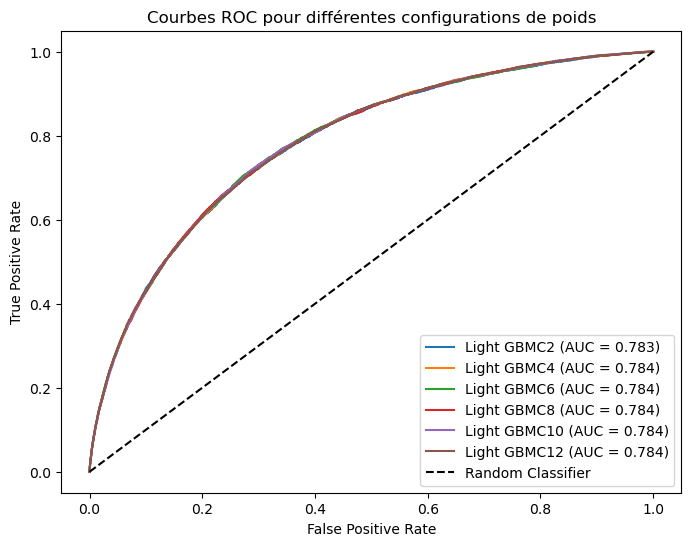

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Générer les courbes ROC pour chaque modèle
plt.figure(figsize=(8, 6))

for name, model in models_list:
    # Prédictions de probabilité pour les classes
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calcul des courbes ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    # Tracer la courbe ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Tracer la diagonale (classification aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Ajout de labels et légendes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC pour différentes configurations de poids')
plt.legend(loc='lower right')
plt.show()

La courbe ROC indique que tous les modèles ont des performances très similaires en termes de séparation des classes. Cela signifie que, pour notre cas d'utilisation, d'autres critères de performance devraient être pris en compte pour choisir la configuration optimale.


**Considérons d'autres facteurs** : nous pourrieons aussi vouloir tenir compte de la robustesse du modèle, du temps de calcul (Run_Duree_Model), ou de la complexité du modèle (nb_variables_utilisees).

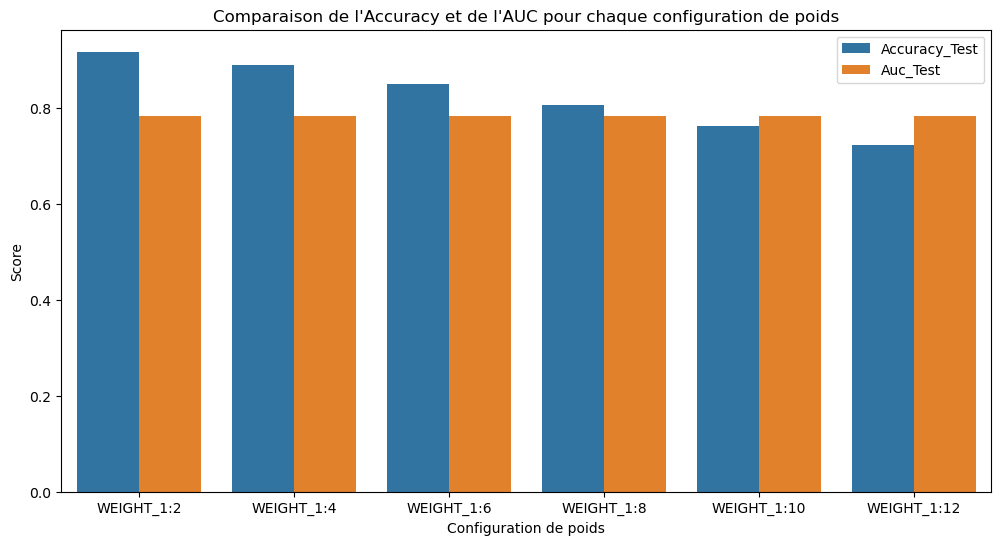

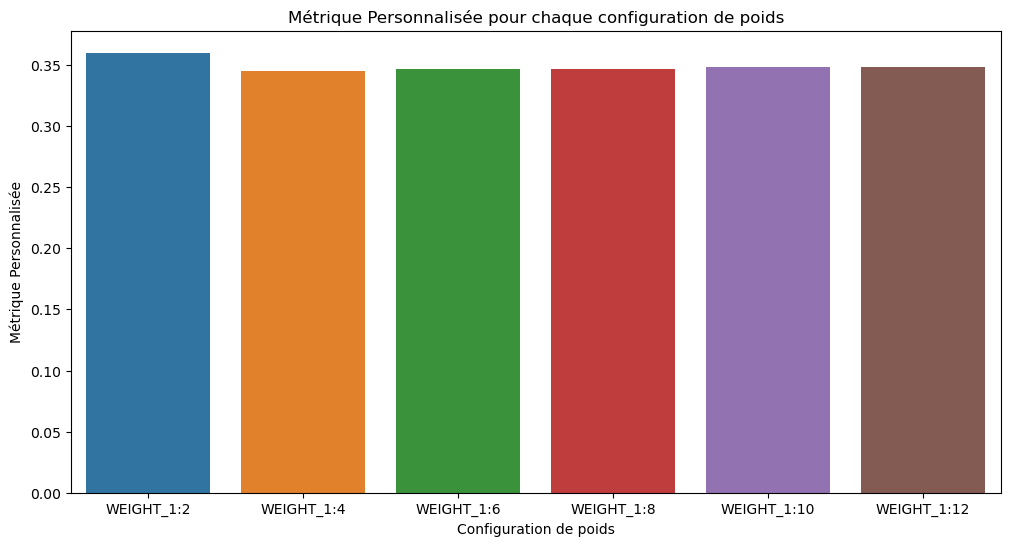

In [53]:
import seaborn as sns

# Comparaison de l'Accuracy et de l'AUC pour chaque configuration
df_melted = df_weight_custom.melt(id_vars='nom_modele', value_vars=['Accuracy_Test', 'Auc_Test'], 
                                  var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='nom_modele', y='Score', hue='Metric', data=df_melted)
plt.title('Comparaison de l\'Accuracy et de l\'AUC pour chaque configuration de poids')
plt.xlabel('Configuration de poids')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='nom_modele', y='Metrique_custom_Train', data=df_weight_custom)
plt.title('Métrique Personnalisée pour chaque configuration de poids')
plt.xlabel('Configuration de poids')
plt.ylabel('Métrique Personnalisée')
plt.show()